In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

%matplotlib inline

In [3]:
plt.rc('font', family='serif', size=16)

In [4]:
def rho_red_light(x, rho_max):
    #sets initial solution
    rho = np.full_like(x, rho_max) #rho will be array size of x, filled with rho_max
    # rho = rho_max* np.ones_like(x) #does the same thing as the above line
    mask = np.where(x < 3.0)
    rho[mask] /= 2
    return rho

In [41]:
# === SIMULATION PARAMETERS ===
nx = 81
L  = 4.0
dx = L / (nx - 1)
x  = np.linspace(0.0, L, num=nx)
T = 5.0
dt = 0.05
nt = int(1 + T / dt)

rho_max = 10.0
u_max   = 1.0

rho0 = rho_red_light(x, rho_max)

In [42]:
def plot(n, x, rho_hist):
    plt.figure()
    plt.grid()
    plt.title("Time Step: {}".format(n))
    plt.xlabel("Road [km]")
    plt.ylabel('Traffic Density [cars/hr]')
    plt.plot(x, rho_hist[n])
    plt.xlim(x[0], x[-1])
    plt.ylim(4.0, 11.0)
    plt.show()

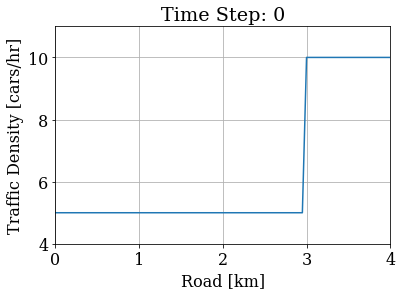

In [43]:
plot(0, x, [rho0])

In [44]:
def traffic_speed(rho, u_max, rho_max):
    return u_max * (1 - rho / rho_max)

def traffic_flux(rho, u_max, rho_max):
    return rho * traffic_speed(rho, u_max, rho_max)

In [45]:
def interactive_plot(x, rho_hist):
    nt = len(rho_hist) - 1
    nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1, description='Time Step')
    w = ipywidgets.interactive(plot, n=nt_slider, x=ipywidgets.fixed(x), rho_hist=ipywidgets.fixed(rho_hist))
    return w

In [63]:
#interactive_plot(x, rho_hist)

In [66]:
#something is wrong in this one :/
def lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = np.zeros([nt, len(rho0)])
    rho_hist[0,:] = rho0

    for i in range(nt-1):
        for j in range(1,nx-1):
            rho_hist[i+1,j] = (0.5*(rho_hist[i,j+1] + rho_hist[i, j-1]) -
                dt * (traffic_flux(rho_hist[i,j+1], u_max, rho_max) -
                     traffic_flux(rho_hist[i, j-1], u_max, rho_max)) / 
                    (2 * dx))
    #ignore boundary conditions because they'll just stay at what they were in rho0,
    #and those values are fine for our boundaries
    return rho_hist

In [78]:
def cleaner_lf(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    nx = len(rho0)
    nx = rho.size
    for n in range(nt):
        rho_n = rho.copy()
        F = traffic_flux(rho_n, u_max, rho_max)
        for i in range(1, nx - 1):
            rho[i] = (0.5 * (rho_n[i+1] + rho_n[i - 1]) -
                     dt * (F[i+1] - F[i - 1]) / (2*dx))
            #rho[1:-1] = 0.5 * (rho[2:] + rho[:-2]) - dt*(F[2:] - F[:-2]) / (2*dx)
        rho_hist.append(rho.copy())
    return rho_hist

In [79]:
r_hist1 = lax_friedrichs(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, r_hist1)

interactive(children=(IntSlider(value=0, description='Time Step', max=79), Output()), _dom_classes=('widget-in…

In [80]:
r_hist2 = cleaner_lf(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, r_hist2)

interactive(children=(IntSlider(value=0, description='Time Step', max=80), Output()), _dom_classes=('widget-in…

In [81]:
sigma = 0.5
dt = sigma * dx / u_max
nt = 80

r_hist3 = cleaner_lf(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, r_hist3)

interactive(children=(IntSlider(value=0, description='Time Step', max=80), Output()), _dom_classes=('widget-in…

In [73]:
def traffic_jacobian(rho, u_max, rho_max):
    J = np.zeros_like(rho)
    J = u_max * (1 - 2*rho / rho_max) 
    return J

In [82]:
def lax_wendroff(rho0, nt, dt, dx, u_max, rho_max):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    nx = len(rho0)
    nx = rho.size
    for n in range(nt):
        rho_n = rho.copy()
        F = traffic_flux(rho_n, u_max, rho_max)
        J = traffic_jacobian(rho_n, u_max, rho_max)
        
        for i in range(1, nx - 1):
            rho[i] = (rho_n[i] - dt *(F[i+1] - F[i-1]) / (2*dx) +
                     dt**2*((J[i+1] + J[i])*(F[i+1] - F[i]) -
                        (J[i] + J[i-1])*(F[i] - F[i-1])) / (4*dx**2))
           
        rho_hist.append(rho.copy())
    return rho_hist

In [83]:
r_hist4 = cleaner_lf(rho0, nt, dt, dx, u_max, rho_max)
interactive_plot(x, r_hist4)

interactive(children=(IntSlider(value=0, description='Time Step', max=80), Output()), _dom_classes=('widget-in…